# Optimizer tweaks

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09 import *

## Imagenette data

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
il = ImageItemList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)

bs=64

train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
nfs = [32]*4

In [ ]:
#export
class Learner():
    def __init__(self, model, data, loss_func, opt=None, opt_func=optim.SGD, lr=None,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func = model,data,loss_func
        assert opt or lr
        if not opt: opt = opt_func(model.parameters(), lr=lr)
        self.opt = opt
        
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally: self('after_fit')

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [ ]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [ ]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [ ]:
%time learn.fit(1)

train: [1.885817773770746, tensor(0.3382, device='cuda:0')]
valid: [2.132822021484375, tensor(0.2980, device='cuda:0')]
CPU times: user 22.7 s, sys: 11.1 s, total: 33.8 s
Wall time: 35.1 s


## Check everything works

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [ ]:
cbfs += [Recorder,
         partial(ParamScheduler, 'lr', sched)]

In [ ]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)
learn.fit(1)

train: [1.821395398295719, tensor(0.3623, device='cuda:0')]
valid: [1.562280029296875, tensor(0.4800, device='cuda:0')]
CPU times: user 12.1 s, sys: 6.11 s, total: 18.3 s
Wall time: 18.7 s


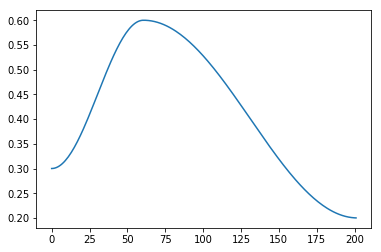

In [ ]:
learn.recorder.plot_lr()

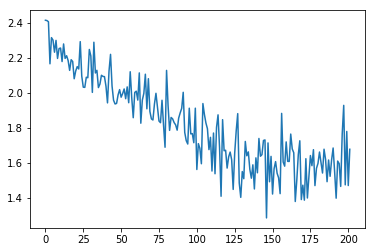

In [ ]:
learn.recorder.plot_loss()

## Export

In [ ]:
!./notebook2script.py 09b_learner.ipynb

Converted 09b_learner.ipynb to nb_09b.py
